# Сессия 3 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn import ensemble
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Чтение csv файла с данными 

In [2]:
df_nan_m = pd.read_csv("clear_data_median_fill.csv", index_col=0)

Чтение файла с таргетами 

In [3]:
tars = pd.read_csv("Outcomes.txt", sep=",")

In [4]:
tars.columns = ['ID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death']

Объединение двух файлов по ID

In [5]:
df_nan_m = pd.merge(df_nan_m,tars,on="ID")

ID можно убрать тк это никак не влияет на состояние пациента

In [6]:
# "ID","SAPS-I","SOFA","Survival","In-hospital_death", "Length_of_stay"
dfMedLos = df_nan_m.drop(["ID"],axis=1)

Заменим все значения -1(`NaN`) на среднее значение по столбцу

In [7]:
for i in dfMedLos.columns:
    dfMedLos[i] = dfMedLos[i].replace(-1, dfMedLos[i].median())

Разделим на признаки и целевую 

In [8]:
X = dfMedLos.drop("Length_of_stay", axis=1)
Y = dfMedLos["Length_of_stay"]

## <======== Для меня ========>
   Функция получение топа фичерзов, но я не уверен как она работает поэтому не пользовался, а только написал. <br>Пусть будет 

In [9]:
import math
import operator
from sklearn.feature_selection import f_regression
def getTopFeatures(train_x, train_y, n_features=100):
    f_val, p_val = f_regression(train_x,train_y)
    f_val_dict = {}
    p_val_dict = {}
    for i in range(len(f_val)):
        if math.isnan(f_val[i]):
            f_val[i] = 0.0
        f_val_dict[i] = f_val[i]
        if math.isnan(p_val[i]):
            p_val[i] = 0.0
        p_val_dict[i] = p_val[i]

    sorted_f = sorted(f_val_dict.items(), key=operator.itemgetter(1),reverse=True)
    sorted_p = sorted(p_val_dict.items(), key=operator.itemgetter(1),reverse=True)
    
    feature_indexs = {}
    for elem in sorted_f:
        feature_indexs[dfMedLos.columns[elem[0]]] = elem[1]
    
    return feature_indexs

## <======== ========>

#### feature_importance
Подсчет значений: на сколько и какие признаки явл важными для нас 

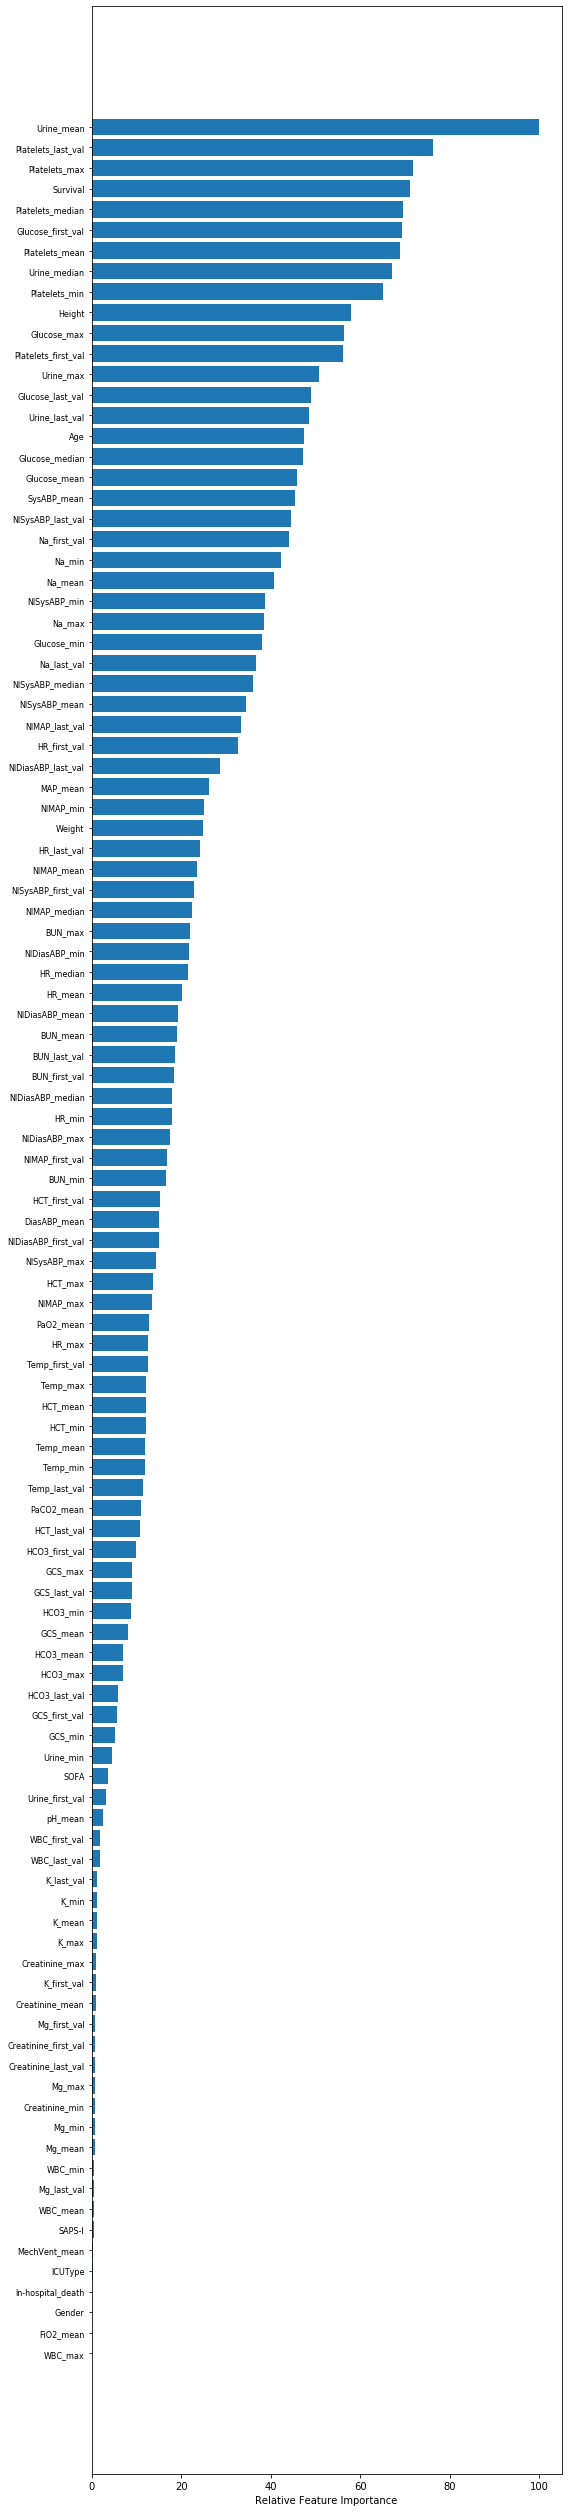

In [10]:
clf = LogisticRegression(random_state = 0)
clf.fit(X, Y)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8,35))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

#plt.figure(figsize=(8,35))
plt.tight_layout()   
plt.show()

Маловыразительные признаки убираем 

In [11]:
tmp={}
drop = []
for i in range(len(np.array(X.columns)[sorted_idx])):
    if feature_importance[sorted_idx][i] > 10:
        tmp[np.array(X.columns)[sorted_idx][i]] = feature_importance[sorted_idx][i]
    else: 
        drop.append(np.array(X.columns)[sorted_idx][i])

In [12]:
X.drop(drop, axis=1, inplace=True)

In [13]:
X.shape

(7603, 70)

Разделение на `train, test, valid`. Тренировочная выборка будет самой большой: 60%, валидационная и тестовая будут одинаковыми по 20%

In [14]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

На примере этих моделей `LinearRegression(), LogisticRegression(), Lasso(), Ridge(), GradientBoostingRegressor()` посмотрим какая из них лучше себя покажет и потом подберем для нее гиперпараметры 

LinearRegression()
0.055276606961168206
LogisticRegression()
0.06837606837606838
Lasso()
0.048276806140719275
Ridge()
0.05527299094824978
GradientBoostingRegressor()
0.12016914043520355


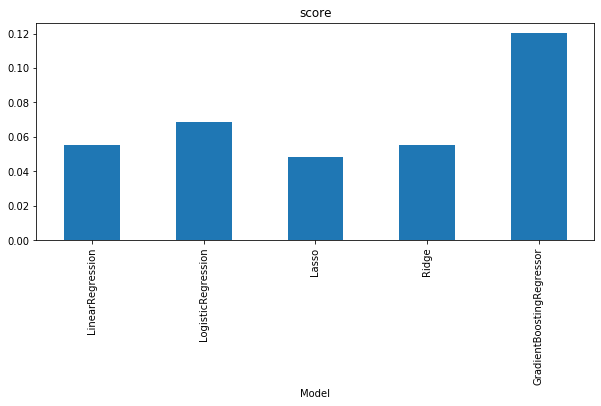

In [15]:
models = [LinearRegression(), 
          LogisticRegression(),
          linear_model.Lasso(), 
          Ridge(), 
          GradientBoostingRegressor()]

TestModels = pd.DataFrame()
tmp = {}
 
for model in models:
    print(model)
    m = str(model)

    model.fit(X_train, y_train)
    print(model.score(X_val, y_val))
    
    tmp['Model'] = m[:m.index('(')]
    tmp['score'] = model.score(X_val, y_val)
    TestModels = TestModels.append([tmp])
TestModels.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
TestModels.score.plot(ax=axes, kind='bar', title='score')
plt.show()


Подбор гиперпараметров для градиентного бустинга, тк он лучше всего себя показал

In [48]:
parameters = {
    "loss":["ls","huber", "quantile"],
    "max_features":["auto", "log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "n_estimators":[10,50,100]
    }


In [51]:
GBR = GradientBoostingRegressor()

gbdf = pd.DataFrame()
tmp = {}
for l in parameters["loss"]:
    for m in parameters["max_features"]:
        for n in parameters["n_estimators"]:
            for c in parameters["criterion"]:
                tmp["loss"] = l
                tmp["max_features"] = m
                tmp["n_estimators"] = n
                tmp["criterion"] = c
                
                GBR.loss = l
                GBR.max_features = m
                GBR.n_estimators = n
                GBR.criterion = c
                GBR.fit(X_train, y_train)
                ac = GBR.score(X_val, y_val)
                tmp["acc"] = ac
                gbdf = gbdf.append([tmp])
                print("|", end="")

||||||||||||||||||||||||||||||||||||||||||||||||||||||

Лучше всего вышло с `loss="huber", max_features="auto", n_estimators=100, criterion="friedman_mse"`

In [53]:
gbdf[gbdf["acc"] == gbdf["acc"].max()]

,loss,max_features,n_estimators,criterion,acc
0,huber,auto,100,friedman_mse,0.126279


In [54]:
LR = GradientBoostingRegressor(loss="huber", max_features="auto", n_estimators=100, criterion="friedman_mse")

Результат на тестовой выборке

In [55]:
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.15685895155585794